In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import f1_score,confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold

## 1 Load the data set

In [2]:
df = pd.read_csv("~/downloads/corona_tested_individuals_ver_00166.csv", header=0, parse_dates = ['test_date']) ## load the date in local
# df_np = np.loadtxt('corona_tested_individuals_ver_00166.csv', delimiter=',', skiprows=1,
#                           usecols= (1,7), unpack=True)
# df = pd.DataFrame(df)
df.columns = ['date','cough','fever','sore_throat','shortness_of_breath','head_ache','corona_result','age','gender','test_indication']

## 2 Data Exploration¶

Explanation of the data:
https://data.gov.il/dataset/covid-19/resource/0ac4cffc-3746-473a-8d4a-ab874b8d8d62

Gender: appears from March 22nd 2020

Corona_result: Results of first Covid-19 test, by category:
    a.Positive – carrying Covid-19
    b.Negative – not carrying Covid-19
    c.Other – Not tested, in testing, inconclusive

Age_60_and_above: Indicator of the test taker's age - 60 or over (1) or below 60 (0). Appears from March 17th 2020.

Test_indication: What is the indication for testing? Abroad – arrived from abroad, contact_with_confirmed – contact with a confirmed case, other – other indication or not specified

Symptoms (whether developed before testing):
cough, fever, sore_throat, shortness of breath, headache: 1 – Yes, 0 – No, NULL – Unknown

The corona_result is the label class.

In [3]:
df = df[df["date"] > "2021-05-30"] # for simplicity and computability for a laptop, use data after 2021-05-30

In [4]:
df.head()

,date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age,gender,test_indication
0,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other
1,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other
2,2021-07-25,1,1,1,0,1,אחר,No,נקבה,Abroad
3,2021-07-25,0,0,0,0,0,שלילי,No,זכר,Other
4,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other


In [5]:
df.shape

(486659, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486659 entries, 0 to 486658
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 486659 non-null  datetime64[ns]
 1   cough                486659 non-null  int64         
 2   fever                486659 non-null  int64         
 3   sore_throat          486659 non-null  int64         
 4   shortness_of_breath  486659 non-null  int64         
 5   head_ache            486659 non-null  int64         
 6   corona_result        486659 non-null  object        
 7   age                  201480 non-null  object        
 8   gender               271191 non-null  object        
 9   test_indication      486659 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 40.8+ MB


In [7]:
df.isnull().sum()

date                        0
cough                       0
fever                       0
sore_throat                 0
shortness_of_breath         0
head_ache                   0
corona_result               0
age                    285179
gender                 215468
test_indication             0
dtype: int64

According to the offical documents, testing for the virus started in February. However,due to privacy concerns:
1. The information is available from 11 March 2020.
2. Ages have been divided to under 60 and 60 and over, and are published from 17 March until 14 April (before 17 March until 14 April age equals NULL)
3. Sex is published from 22 March (before the date, sex was represented as NULL)

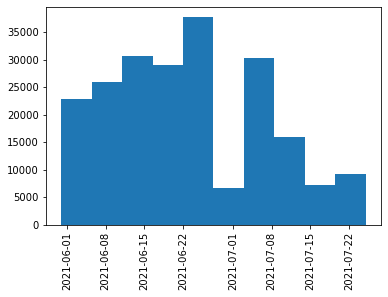

In [8]:
plt.hist(df[df["gender"].isnull()]['date'], bins = 10)
plt.xticks(rotation='vertical');

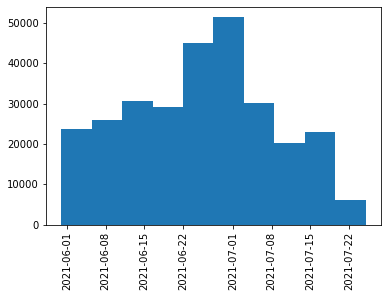

In [9]:
plt.hist(df[df["age"].isnull()]['date'], bins = 10)
plt.xticks(rotation='vertical');

In [10]:
pd.concat([
    df.describe().T,
    df.mad().rename('mad'),
    df.skew().rename('skew'),
    df.kurt().rename('kurt'),
    df.nunique().rename('nunique')
], axis=1).T

,cough,fever,sore_throat,shortness_of_breath,head_ache,date,corona_result,age,gender,test_indication
count,486659.000000,486659.000000,486659.000000,486659.000000,486659.000000,NaN,NaN,NaN,NaN,NaN
mean,0.005190,0.004886,0.001942,0.000271,0.003339,NaN,NaN,NaN,NaN,NaN
std,0.071858,0.069732,0.044023,0.016467,0.057688,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
75%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
max,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
mad,0.010327,0.009725,0.003876,0.000542,0.006656,NaN,NaN,NaN,NaN,NaN
skew,13.771940,14.200588,22.627156,60.694593,17.218816,NaN,NaN,NaN,NaN,NaN


In [11]:
df['corona_result'].unique() 

array(['שלילי', 'אחר', 'חיובי'], dtype=object)

In [12]:
# replacing all the characters in Hebrew by English
df['corona_result'] = df['corona_result'].str.replace('חיובי','Positive')
df['corona_result'] = df['corona_result'].str.replace('אחר','Other')
df['corona_result'] = df['corona_result'].str.replace('שלילי','Negative')

df['gender'] = df['gender'].str.replace('נקבה','Female')
df['gender'] = df['gender'].str.replace('זכר','Male')

## 3 Data Understanding

**BreakDown of Class**

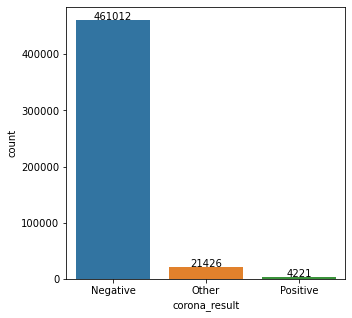

In [13]:
plt.figure(figsize=(5,5))
corona_result = sns.countplot(df['corona_result'],label="Count")

for p in corona_result.patches:
    height = p.get_height()
    corona_result.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

The class lable is highly imbalanced. The proportion of positive instances is less than **1%**. We need to be cautious about this.

**BreakDown of feature distribution**

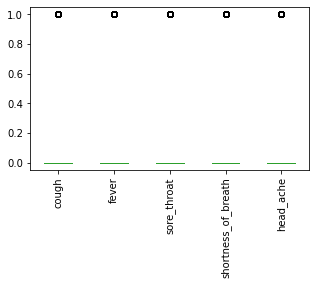

In [14]:
df.plot.box(figsize=(5, 3)) # visualize the feature distribution
plt.xticks(rotation='vertical');
# the value distribution of 5 numeric features are highly skewed with over 75% being 0.

**BreakDown of cough**

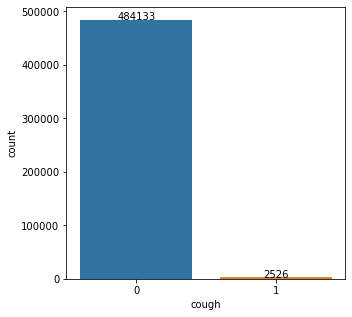

In [15]:
plt.figure(figsize=(5,5))
cough = sns.countplot(data=df, x="cough")

for p in cough.patches:
    height = p.get_height()
    cough.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

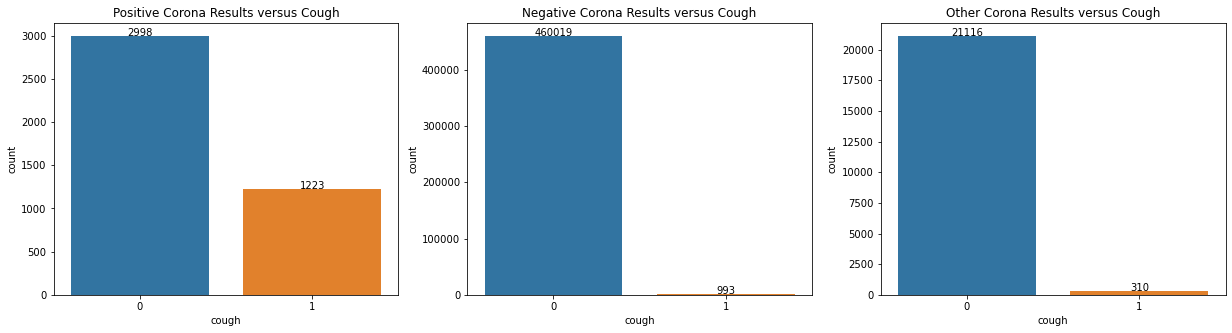

In [16]:
f, axes = plt.subplots(1, 3, figsize=(21,5))
positive = sns.countplot(df[df['corona_result'] == 'Positive']["cough"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus Cough")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["cough"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus Cough')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["cough"], ax=axes[2])
axes[2].set_title('Other Corona Results versus Cough')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of fever**

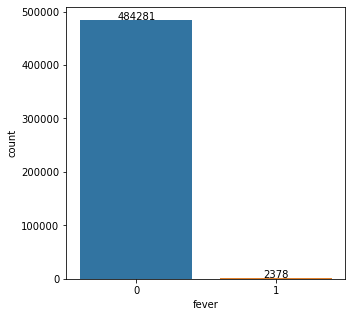

In [17]:
plt.figure(figsize=(5,5))
fever = sns.countplot(data=df, x="fever")

for p in fever.patches:
    height = p.get_height()
    fever.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

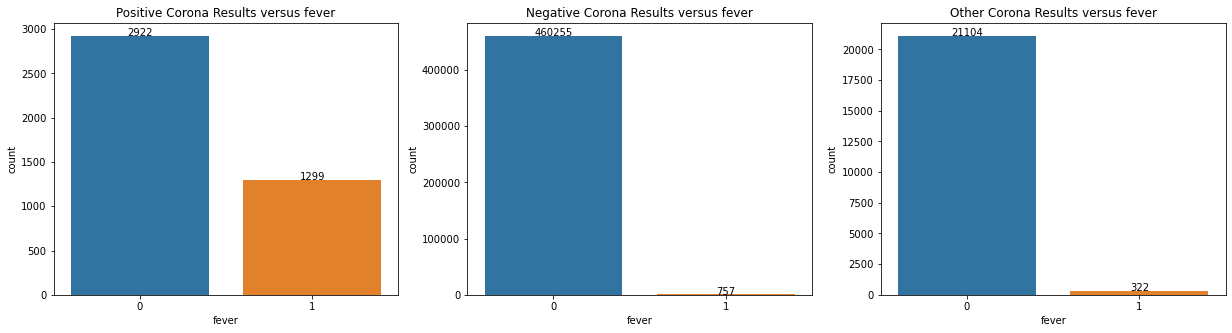

In [18]:
f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["fever"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus fever")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["fever"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus fever')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["fever"], ax=axes[2])
axes[2].set_title('Other Corona Results versus fever')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of sore_throat**

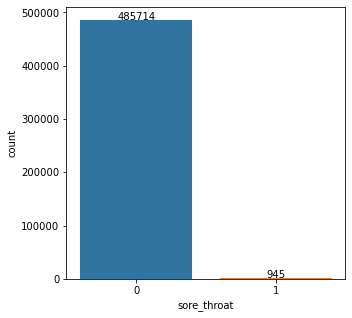

In [19]:
plt.figure(figsize=(5,5))
sore_throat = sns.countplot(data=df, x="sore_throat")

for p in sore_throat.patches:
    height = p.get_height()
    sore_throat.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")



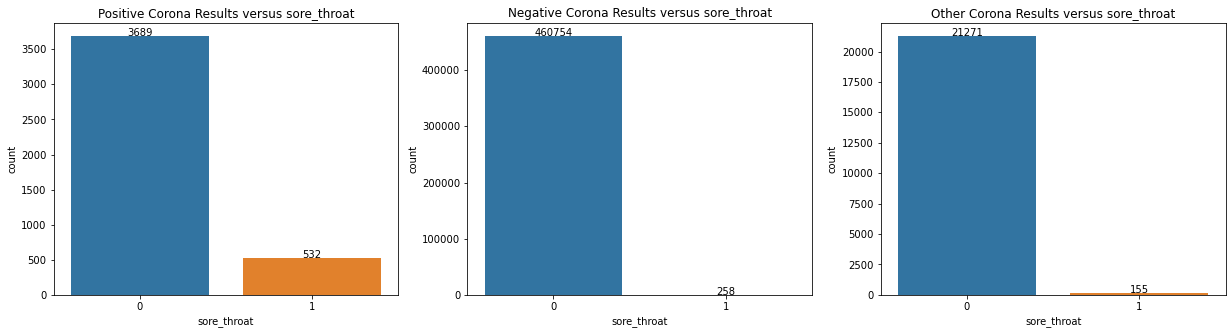

In [20]:
f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["sore_throat"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus sore_throat")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["sore_throat"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus sore_throat')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["sore_throat"], ax=axes[2])
axes[2].set_title('Other Corona Results versus sore_throat')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of shortness_of_breath**

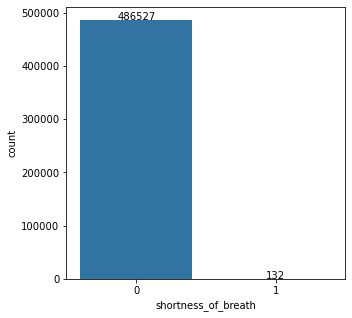

In [21]:
plt.figure(figsize=(5,5))
shortness_of_breath = sns.countplot(data=df, x="shortness_of_breath")

for p in shortness_of_breath.patches:
    height = p.get_height()
    shortness_of_breath.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.show()

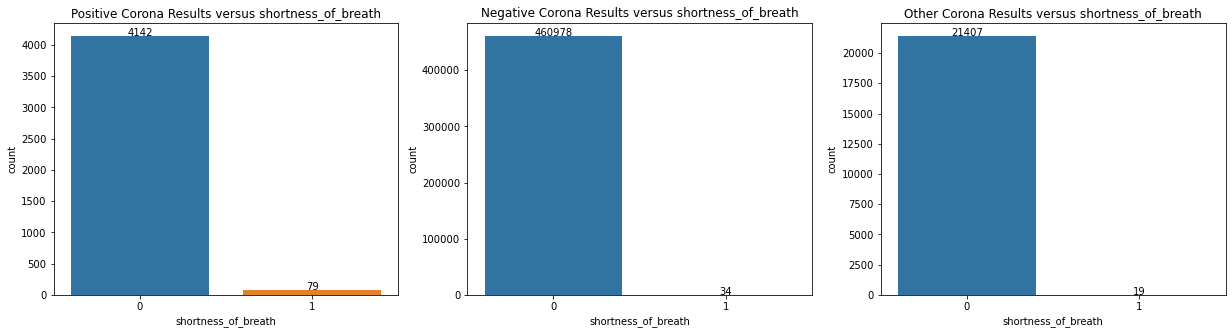

In [22]:
f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["shortness_of_breath"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus shortness_of_breath")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["shortness_of_breath"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus shortness_of_breath')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["shortness_of_breath"], ax=axes[2])
axes[2].set_title('Other Corona Results versus shortness_of_breath')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of head_ache**

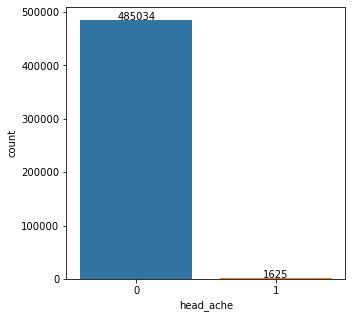

In [23]:
plt.figure(figsize=(5,5))
head_ache = sns.countplot(data=df, x="head_ache")

for p in head_ache.patches:
    height = p.get_height()
    head_ache.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.show()

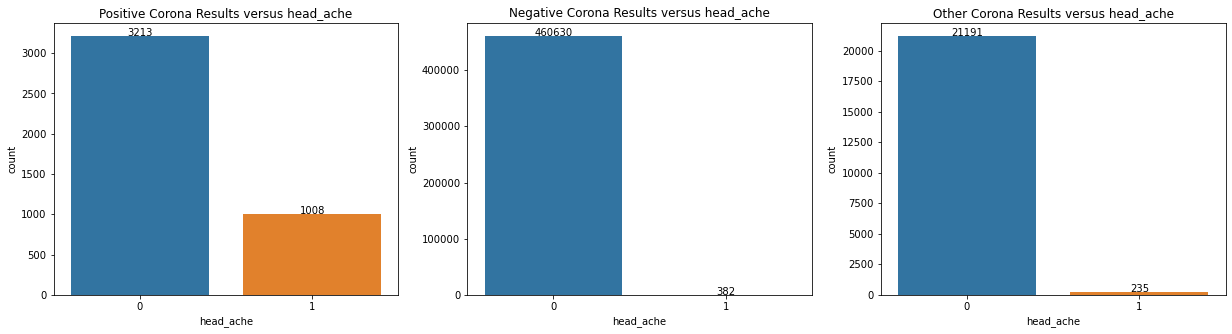

In [24]:
f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["head_ache"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus head_ache")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["head_ache"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus head_ache')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["head_ache"], ax=axes[2])
axes[2].set_title('Other Corona Results versus head_ache')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()

**Corona Result along with time**

In [25]:
matplotlib.style.use('seaborn-white')

In [26]:
df

,date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age,gender,test_indication
0,2021-07-25,0,0,0,0,0,Negative,No,Female,Other
1,2021-07-25,0,0,0,0,0,Negative,No,Female,Other
2,2021-07-25,1,1,1,0,1,Other,No,Female,Abroad
3,2021-07-25,0,0,0,0,0,Negative,No,Male,Other
4,2021-07-25,0,0,0,0,0,Negative,No,Female,Other
...,...,...,...,...,...,...,...,...,...,...
486654,2021-05-31,0,0,0,0,0,Negative,NaN,NaN,Other
486655,2021-05-31,0,0,0,0,0,Negative,NaN,NaN,Other
486656,2021-05-31,0,0,0,0,0,Negative,NaN,NaN,Other
486657,2021-05-31,0,0,0,0,0,Negative,NaN,NaN,Other


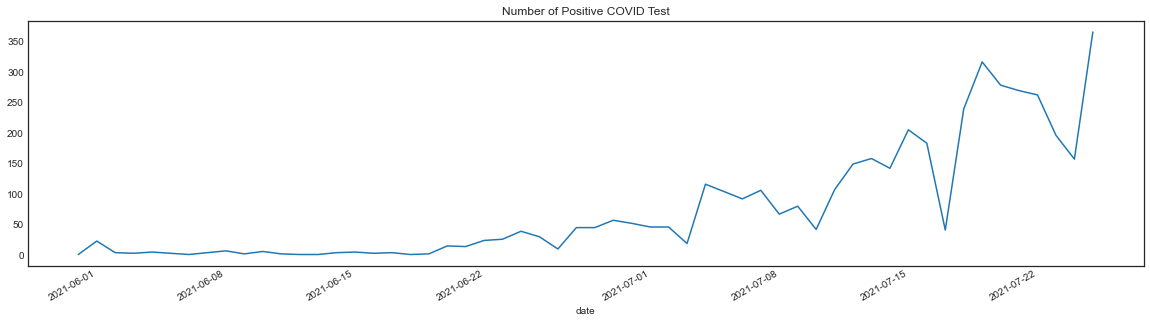

In [27]:
df[df['corona_result'] == "Positive"].groupby('date').size().plot(figsize=(20, 5), title="Number of Positive COVID Test");

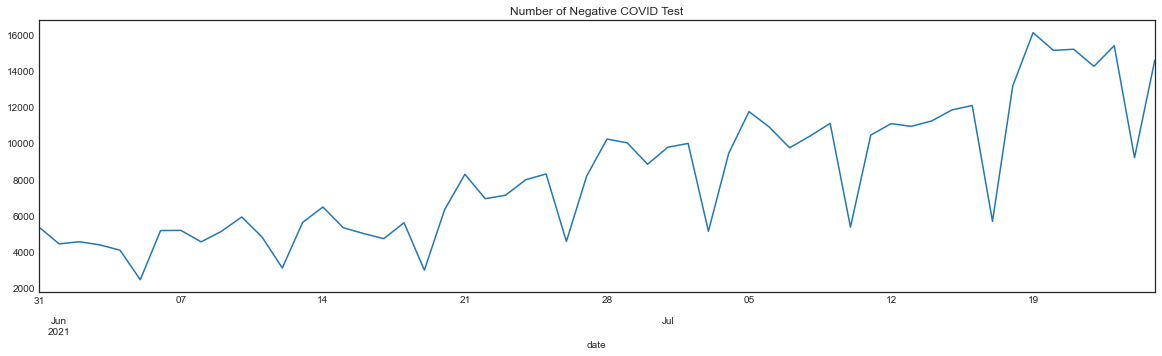

In [28]:
df[df['corona_result'] == "Negative"].groupby('date').size().plot(figsize=(20, 5), title="Number of Negative COVID Test");

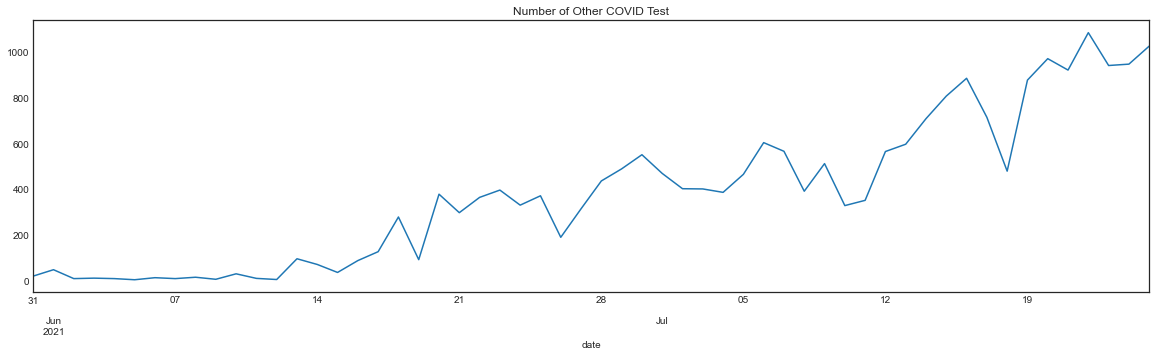

In [29]:
df[df['corona_result'] == "Other"].groupby('date').size().plot(figsize=(20, 5), title="Number of Other COVID Test");

In [ ]:
import pandas as pd, datetime as dt

df_weekly = pd.DataFrame(df.apply(lambda row: row['date'] - dt.timedelta(days=row['date'].weekday()), axis=1), columns = ['WeekDate'])
df_weekly['WeekDate'] = pd.to_datetime(df_weekly['WeekDate']).dt.date

perweek = df_weekly['WeekDate'].groupby(df_weekly['WeekDate']).count()
perweek.plot(kind="bar", figsize=(20, 5));
plt.title("Total COVID Test Per Week")
plt.xlabel("Week Date")
plt.ylabel("Test Counts")
plt.show()

Combining what we have analyzed above, the volume of test cases varies week by week but is generally trending upwards.

## 4 Data Preprocessing

**Remove the instances with results of *Others* (not tested, testing)**

In [ ]:
df = df[df['corona_result'] != 'Other']
df = df.drop("date", axis = 1)

### Imputation

In [ ]:
# How many features have missing values?
n_missing = len(df.columns[df.isnull().any()])
"{} features have missing values.".format(n_missing)

In [ ]:
keys = ['Total', 'Percent']

null_total = df.isnull().sum().sort_values(ascending=False)
null_percent = (df.isnull().sum() /df.isnull().count())

df_missing = pd.concat([null_total, null_percent], axis=1, keys=keys, sort=False)
df_missing = df_missing.sort_values(by='Percent', ascending=False)
df_missing.head(n_missing)

The percentage of the missing values is large. We will test on filled and dropped datasets and see if one improves the accuracy

In [ ]:
# replace the missing value
X_filled = df.copy().drop("corona_result", axis = 1)
y_filled = df.copy()["corona_result"]
X_filled_nom = X_filled.select_dtypes(include=[object])
X_filled_num = X_filled.select_dtypes(include=[np.number])

X_filled[X_filled_nom.columns] = X_filled_nom.fillna('Missing')
X_filled.head()

In [ ]:
# drop the rows with missing value
df_dropped = df.dropna(how = 'any', axis=0)
X_dropped = df_dropped.drop("corona_result", axis = 1)
y_dropped = df_dropped["corona_result"]

In [ ]:
n_missing = len(X_dropped.columns[X_dropped.isnull().any()])
"{} features have missing values.".format(n_missing)

### Encoding

In [ ]:
X_filled_nom_trans = pd.get_dummies(X_filled[X_filled_nom.columns])

In [ ]:
X_filled = pd.concat([X_filled_num, X_filled_nom_trans], axis = 1)

In [ ]:
X_filled.head()

**When dropping the missing value, the two nominal features (gender and age) are all binary feature. Thus we can encode these features as 0 and 1**

In [ ]:
# gender and age features are binary so use labelEncoder to be consistent with the syndrome features (binary)
le = LabelEncoder()
le.fit(X_dropped["gender"])
X_dropped["gender"] = le.transform(X_dropped["gender"])
le.fit(X_dropped["age"])
X_dropped["age"] = le.transform(X_dropped["age"])
# X_indication have multi variable so use get dummies instead. OneHotEncoder can't convert df with some string
X_indication = pd.get_dummies(X_dropped["test_indication"])
X_dropped = pd.concat([X_dropped.drop("test_indication", axis=1), X_indication], axis=1)

In [ ]:
X_dropped.head()

**Encoding the class label value**

In [ ]:
le.fit(y_dropped)
y_dropped = le.transform(y_dropped)
le.fit(y_filled)
y_filled = le.transform(y_filled)

NOTE: moved feature selection to after modeling as we want to see the baseline performance scores and some features selections are based on models

<!-- **Correlation between features in X_dropped (missing values dropped)** -->

## Feature selection

https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection

Conclusion drawn from the above article:
SelectKBest with Fisher Score
Recursive Feature Elimination with Cross-Validation (RFECV)
Correlation-matrix with heatmap
Random-Forest Importance

**Performance metrics tailored for imbalanced data**

https://imbalanced-learn.org/stable/references/metrics.html#module-imblearn.metrics

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import sensitivity_specificity_support
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import macro_averaged_mean_absolute_error

In [ ]:
def evaluate_imbalanced(y_test, y_pred):
    output = dict()
    output["Balanced Accuracy"] = balanced_accuracy_score(y_test, y_pred)
    output["Sensitivity"] = sensitivity_score(y_test, y_pred, average='weighted') ## high indicates low false negative
    output["Specificity"] = specificity_score(y_test, y_pred, average='weighted') ## high indicates low false positive
    output["AUROC"] = roc_auc_score(y_test, y_pred) ##TPR
    output["F1"] = f1_score(y_test, y_pred, average="binary") ##weighted precision and recall (both positive dominated)
    output["Geometric Mean"] = geometric_mean_score(y_test, y_pred, average='weighted') ## class-wise sensitivity
    output["Macro Average MAE"] = macro_averaged_mean_absolute_error(y_test, y_pred)
    return output

1. The sensitivity is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The sensitivity quantifies the ability to avoid false negatives. The best value is 1 and the worst value is 0.

2. 'weighted':
Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

3. The specificity is the ratio tn / (tn + fp) where tn is the number of true negatives and fp the number of false positives. The specificity quantifies the ability to avoid false positives. The best value is 1 and the worst value is 0.

4. The geometric mean (G-mean) is the root of the product of class-wise sensitivity. 

5. This function computes each MAE for each class and average them, giving an equal weight to each class.

## Original performance without feature selection

In [ ]:
# prepare a df to store the results from each method
# TO DO: random_state, most cases are 42 or 43 why?
x_train, x_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=0.2, random_state=0)


In [ ]:
#random forest classifier with n_estimators=10 (default) tree-based model is well-suited for imbalanced data
def make_y_pred(x_train, x_test, y_train):
    model_ori = RandomForestClassifier(random_state=43)      
    model_ori = model_ori.fit(x_train,y_train)
    y_pred = model_ori.predict(x_test)
    return y_pred

In [ ]:
y_pred = make_y_pred(x_train, x_test, y_train)

In [ ]:
results_1 = pd.DataFrame(evaluate_imbalanced(y_test, y_pred).items(),columns=[ 'Method', 'Original'])
results_1

In [ ]:
def make_confusion_matrix(y_test,y_pred):
    cf_matrix = confusion_matrix(y_test,y_pred)
    fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Greens', linewidths=.1, ax=ax);
    ax.set_title('Confusion Matrix');

In [ ]:
make_confusion_matrix(y_test,y_pred)

## Feature selection--Filter method

**1. Mutual Info between features and class label (drop date column for now)**

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

In [ ]:
mi_reg = mutual_info_regression(X_filled, y_filled)
mi_cla = mutual_info_regression(X_filled, y_filled)

In [ ]:
df_mi = pd.DataFrame(mi_reg, index=X_filled.columns, columns=['mutual_info_reg'])

In [ ]:
def highlight_top6(s):
    """Highlight the maximum in a Series green."""
    is_large = s.nlargest(6).values
    return ['background-color: green' if v in is_large else '' for v in s ]

In [ ]:
# top 6 are highlighted
df_mi.sort_values("mutual_info_reg", ascending=False).style.apply(highlight_top6)

**Most features are nearly independent. No feature filtered out with this method**

In [ ]:
# for scoring only, need to combine with other methods
from sklearn.feature_selection import f_regression, f_classif
f_reg = f_regression(X_filled, y_filled)
f_clasif = f_classif(X_filled, y_filled)

**2. Correlation matrix with heatmap for features in X_filled (missing values filled)**

In [ ]:
# corr for mean
corr1 = X_filled.corr();
corr2 = X_dropped.corr();

In [ ]:
plt.rc("figure", figsize=(15, 15))
grid=sns.heatmap(corr1,annot=True,cbar = True, square = True, cmap=sns.diverging_palette(220, 10, as_cmap=True))
grid.set_xticklabels(corr1.columns,rotation=90)
plt.subplots_adjust(left=0.3,right=1,bottom=0.35,top=0.9)
plt.show()

**Findings: The correlations between any two features are low. No correlation is higher than 0.9. No feature filtered out with this method**

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
# # refresher
x_train, x_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=0.2, random_state=0)

In [ ]:
# find best scored 5 features
selector = SelectKBest(chi2, k=5)
select_feature = selector.fit(x_train, y_train)
df_chi2 = pd.DataFrame(select_feature.scores_, index=x_train.columns, columns=['SelectKBest-chi2'])
df_chi2.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

In [ ]:
# side-by-side comparison with mi
merged = df_chi2.join(df_mi)
merged.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

In [ ]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)

y_pred = make_y_pred(x_train_2, x_test_2, y_train)

In [ ]:
results_select = pd.DataFrame(evaluate_imbalanced(y_test, y_pred).items(),columns=[ 'Method', 'SelectedKBest-chi2'])
results_select

In [ ]:
results = results_1.set_index('Method').join(results_select.set_index('Method'))
results['%'] = (((results['SelectedKBest-chi2'] - results['Original']) / results['Original'])*100 ).round(2).astype(str) + '%'
results

In [ ]:
make_confusion_matrix(y_test,y_pred)

## Feature selection--Wrapper method

**Recursive feature elimination (RFE) with random forest**

In [ ]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
# using the same classifer as original 
model_ori = RandomForestClassifier(random_state=43)
rfe = RFE(estimator=model_ori, n_features_to_select=6, step=1)
rfe = rfe.fit(x_train, y_train)

In [ ]:
df_rfe = pd.DataFrame(rfe.support_, index=x_train.columns, columns=['RFE'])
df_rfe.sort_values('RFE', ascending=False).style.apply(highlight_top6)

In [ ]:
merged = df_mi.join(df_chi2.join(df_rfe))
merged.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

**Findings: align mostly with SelectedKBest and the same as MI**

In [ ]:
# TO DO:
# Why MI and RFE have test_indication_other

## <font color='red'> DO NOT RUN THE SECTION BELOW THROUGH THE RFECV TABLE, THIS WILL TAKE FOREVER</font> 



**Recursive feature elimination with cross validation and random forest classification**

In [ ]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
# using the same classifer as original 
# rfecv = RFECV(estimator=model_ori, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
# rfecv = rfecv.fit(x_train, y_train)

In [ ]:
# df_RFECV = pd.DataFrame(rfecv.n_features_, index=x_train.columns, columns=['RFECV'])
# df_RFECV.sort_values('RFECV', ascending=False).style.apply(highlight_top6)

grid_scores_ : array of shape [n_subsets_of_features]
The cross-validation scores such that grid_scores_[i] corresponds to the CV score of the i-th subset of features.

In [ ]:
# Plot number of features VS. cross-validation scores
# import matplotlib.pyplot as plt
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score of number of selected features")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

**Findings: we can observe the validation score peaks at 8 features**

## Embedded Methods

**Random Forest Importance**

In [ ]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [ ]:
df_RF_importance = pd.DataFrame(clr_rf_5.feature_importances_, index=x_train.columns, columns=['RF_importance'])
df_RF_importance.sort_values('RF_importance', ascending=False).style.apply(highlight_top6)

In [ ]:
merged = merged.join(df_RF_importance)
merged.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

In [ ]:
#  to determine how many should be selected

# Plot the feature importances of the forest
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
     color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

**Feature Extraction with PCA**

In [ ]:
#  to determine how many should be selected
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_');

6 features are definitely enough

**Conclusion: We believe it's safe to select the top 6 features: 
'test_indication_Contact with confirmed', 'head_ache', 'fever', 'cough','sore_throat','shortness_of_breath'

**TO DO:
    validate if test_indication_Other should be dropped

In [ ]:
#prepare the selected dataset with the 6th being test_indication_Other
selected_columns = ['test_indication_Contact with confirmed', 'head_ache', 'fever', 'cough','sore_throat','test_indication_Other']
# X_selected = X_filled.drop("corona_result", axis = 1)
X_selected = X_filled[X_filled.columns[X_filled.columns.isin(selected_columns)]]

In [ ]:
# update the train and test split
x_train, x_test, y_train, y_test = train_test_split(X_selected, y_filled, test_size=0.2, random_state=0)

In [ ]:
y_pred = make_y_pred(x_train, x_test, y_train)

In [ ]:
results_other = pd.DataFrame(evaluate_imbalanced(y_test, y_pred).items(),columns=['Method', 'All other 5 methods'])
results_other

In [ ]:
# results = results.set_index('Method').join(results_other.set_index('Method'))
results = results_1.set_index('Method').join(results_select.set_index('Method')).join(results_other.set_index('Method'))
results['original vs other 5 %'] = (((results['All other 5 methods'] - results['Original']) / results['Original'])*100 ).round(2).astype(str) + '%'
results['original sel-chi2 %'] = (((results['SelectedKBest-chi2'] - results['Original']) / results['Original'])*100 ).round(2).astype(str) + '%'

results

**test_indication_other has a positive effect on the performance metrics. We decide to add it as the seventh feature**

**TO DO:
    selecting a subset from df.copy() may need to redo the normalization

In [ ]:
# prepare the selected dataset with the 6th feature being shortness_of_breath and 7th feature being test_indication_Other
selected_columns = ['test_indication_Contact with confirmed', 'head_ache', 'fever', 'cough','sore_throat','shortness_of_breath', 'test_indication_Other']
X_selected = X_filled[X_filled.columns[X_filled.columns.isin(selected_columns)]]
y_selected = y_filled

In [ ]:
# update the train and test split
x_train, x_test, y_train, y_test = train_test_split(X_selected, y_filled, test_size=0.2, random_state=0)

## Imbalanced sampling

https://imbalanced-learn.org/stable/over_sampling.html#naive-random-over-sampling

pip install imbalanced-learn

In [ ]:
X = X_selected.copy()
Y = y_selected.copy()
print(X.shape)
print(Y.shape)

**Oversampling: Naive Random Over-Sampling (ROS) to increase the sample size of under-represented data by replication with replacement**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
def oversample(X, Y):
    ros = RandomOverSampler(random_state=0)
    return ros.fit_resample(X, Y)

**Oversampling:SMOTE based on KNN and generating new samples**

In [ ]:
from imblearn.over_sampling import SMOTE
def oversample_smote(X, Y):
    return SMOTE().fit_resample(X, Y)

**Under-sampling:Random Under-Sampler (RUS) is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
def undersample(X, Y):
    rus = RandomUnderSampler(random_state=0)
    return rus.fit_resample(X, Y)

## Modeling

**the paramter of all classifier are tested and determined to be optimal by prior demos.**

In [ ]:
models = {
    "Dummy Classifier" : DummyClassifier(strategy='uniform'), # dummy classifier to predict randomly
    "Most Frequent Clasifier" : DummyClassifier(strategy='most_frequent'), # dummy classifier to always predict the majority
    "Perceptron": Perceptron(alpha = 0.1),
    "Decision Tree (max_depth=None)": DecisionTreeClassifier(max_depth=None, random_state=0),
    "GNB": GaussianNB(),
    "RandomForest": RandomForestClassifier(random_state=0, n_estimators = 101),
    "GradientBoostingForest": GradientBoostingClassifier(random_state=0, n_estimators = 101),
    "XGBoost": XGBClassifier(n_estimators=1000, tree_method='hist', random_state=0, eval_metric='mlogloss')
}

**Apply Neural Netword model to the dataset**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
# define the keras model
nmodel = Sequential()
# add layers
nmodel.add(Dense(12, input_dim=7, activation='relu'))
nmodel.add(Dense(7, activation='relu'))
nmodel.add(Dense(1, activation='sigmoid'))
nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy', 'AUC'])
models['Neural Network'] = nmodel

In [ ]:
def thresholding(pred, y): # threasholding the continuous predicted value to binary labels
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y, pred)
    # use gemans to select the optimal threshold
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    threshold = thresholds[ix]
    for i in range(len(y)):
        pred[i] = 1 if pred[i] >= threshold else 0
    return pred

### original sampling

In [ ]:
n_splits = 10;
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
prediction = dict() # store the metrics
prediction_train = dict() # store the metrics for the trainning set
for train_index, test_index in skf.split(X, Y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    for classif_name in models.keys():
        classif = models[classif_name]
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test) # test
        # threasholding the continuous predicted value to binary labels
        y_pred = thresholding(y_pred, y_test)
        output = evaluate_imbalanced(y_test, y_pred)
        y_pred_train = classif.predict(X_train) # train
        # threasholding the continuous predicted value to binary labels
        y_pred_train = thresholding(y_pred_train, y_train)
        output_train = evaluate_imbalanced(y_train, y_pred_train)
        ## store the metrics in a dict
        if classif_name in prediction:
            for metric in prediction[classif_name].keys():
                prediction[classif_name][metric] += output[metric]
                prediction_train[classif_name][metric] += output_train[metric]
        else:
            prediction[classif_name] = output
            prediction_train[classif_name] = output_train

In [ ]:
# calculate the avereage of metrics for k-folds
for classif_name in prediction.keys():
    for metric in prediction[classif_name].keys():
        prediction[classif_name][metric] /= n_splits
        prediction_train[classif_name][metric] /= n_splits

In [ ]:
results = pd.DataFrame([prediction[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

In [ ]:
results_train = pd.DataFrame([prediction_train[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

### over sampling

In [ ]:
n_splits = 10;
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
prediction = dict() # store the metrics
prediction_train = dict() # store the metrics for the trainning set
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train, y_train = oversample(X_train, y_train)
    for classif_name in models.keys():
        classif = models[classif_name]
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test) # test
        # threasholding the continuous predicted value to binary labels
        y_pred = thresholding(y_pred, y_test)
        output = evaluate_imbalanced(y_test, y_pred)
        y_pred_train = classif.predict(X_train) # train
        # threasholding the continuous predicted value to binary labels
        y_pred_train = thresholding(y_pred_train, y_train)
        output_train = evaluate_imbalanced(y_train, y_pred_train)
        ## store the metrics in a dict
        if classif_name in prediction:
            for metric in prediction[classif_name].keys():
                prediction[classif_name][metric] += output[metric]
                prediction_train[classif_name][metric] += output_train[metric]
        else:
            prediction[classif_name] = output
            prediction_train[classif_name] = output_train

In [ ]:
# calculate the avereage of metrics for k-folds
for classif_name in prediction.keys():
    for metric in prediction[classif_name].keys():
        prediction[classif_name][metric] /= n_splits
        prediction_train[classif_name][metric] /= n_splits

In [ ]:
results = pd.DataFrame([prediction[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

In [ ]:
results = pd.DataFrame([prediction_train[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

### over sampling with SMOTE

In [ ]:
n_splits = 10;
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
prediction = dict() # store the metrics
prediction_train = dict() # store the metrics for the trainning set
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train, y_train = oversample_smote(X_train, y_train)
    for classif_name in models.keys():
        classif = models[classif_name]
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test) # test
        # threasholding the continuous predicted value to binary labels
        y_pred = thresholding(y_pred, y_test)
        output = evaluate_imbalanced(y_test, y_pred)
        y_pred_train = classif.predict(X_train) # train
        # threasholding the continuous predicted value to binary labels
        y_pred_train = thresholding(y_pred_train, y_train)
        output_train = evaluate_imbalanced(y_train, y_pred_train)
        ## store the metrics in a dict
        if classif_name in prediction:
            for metric in prediction[classif_name].keys():
                prediction[classif_name][metric] += output[metric]
                prediction_train[classif_name][metric] += output_train[metric]
        else:
            prediction[classif_name] = output
            prediction_train[classif_name] = output_train

In [ ]:
# calculate the avereage of metrics for k-folds
for classif_name in prediction.keys():
    for metric in prediction[classif_name].keys():
        prediction[classif_name][metric] /= n_splits
        prediction_train[classif_name][metric] /= n_splits

In [ ]:
results = pd.DataFrame([prediction[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

In [ ]:
results = pd.DataFrame([prediction_train[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

### under sampling

In [ ]:
n_splits = 10;
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
prediction = dict() # store the metrics
prediction_train = dict() # store the metrics for the trainning set
for train_index, test_index in skf.split(X_undersampled, y_undersampled):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train, y_train = undersample(X_train, y_train)
    for classif_name in models.keys():
        classif = models[classif_name]
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test) # test
        # threasholding the continuous predicted value to binary labels
        y_pred = thresholding(y_pred, y_test)
        output = evaluate_imbalanced(y_test, y_pred)
        y_pred_train = classif.predict(X_train) # train
        # threasholding the continuous predicted value to binary labels
        y_pred_train = thresholding(y_pred_train, y_train)
        output_train = evaluate_imbalanced(y_train, y_pred_train)
        ## store the metrics in a dict
        if classif_name in prediction:
            for metric in prediction[classif_name].keys():
                prediction[classif_name][metric] += output[metric]
                prediction_train[classif_name][metric] += output_train[metric]
        else:
            prediction[classif_name] = output
            prediction_train[classif_name] = output_train

In [ ]:
# calculate the avereage of metrics for k-folds
for classif_name in prediction.keys():
    for metric in prediction[classif_name].keys():
        prediction[classif_name][metric] /= n_splits
        prediction_train[classif_name][metric] /= n_splits

In [ ]:
results = pd.DataFrame([prediction[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

In [ ]:
results = pd.DataFrame([prediction_train[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)